# One row per patient model

To keep it simple, to start off with we simply model the patients as a single row, i.e. each feature is a scalar or a categorical variable.

See `03_mortality_pred_dataset` notebook for more info.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import clear_output

establish connection to DB and define helper function for running queries

In [2]:
from neoglia.etl.config import SSHInfoEicu, DBInfoEicu
from neoglia.etl.utils import connect_to_db_via_ssh, run_eicu_query, get_column_completeness, load_schema_for_modelling
conn = connect_to_db_via_ssh(SSHInfoEicu, DBInfoEicu)
cursor = conn.cursor()
query_schema = 'set search_path to eicu_crd;'

#### Load data, get target variable

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc

import tensorflow as tf
import keras_metrics as km
from keras.models import load_model
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
# load vars
df = pd.read_csv('orpp_all.csv').set_index('patientunitstayid')

# load targets
query = """
select p.patientunitstayid, i.hosp_mort, icu_los_hours
from patient_top5hospitals_mort_dataset p
inner join icustay_detail i
on p.patientunitstayid=i.patientunitstayid
"""
df_y = run_eicu_query(query, conn).set_index('patientunitstayid')

# there are 100 missing mortality labels, we impute them with zero
#re-order y vars to match the order of X
df_y.fillna(0, inplace=True)
df_y = df_y.loc[df.index]
df_y.to_csv('icustay_y.csv')

#### Setup encoders for the categorical input vars

In [5]:
cat_encoders = {
    'ethnicity': LabelEncoder(),
    'hospital_region': LabelEncoder(),
    'unittype': LabelEncoder(),
    'apachedxgroup': LabelEncoder()
}
for col, label_encoder in cat_encoders.items():
    df[col] = label_encoder.fit_transform(df[col])

#### Scale numeric input features

In [6]:
cat_vars = [
    'ethnicity',
    'hospital_region',
    'unittype',
    'apachedxgroup'
]
num_cols = list(df.columns[4:].values)

# originally I didn't scale the embed dimensions, but this turned out to be terrible and made 
# the training of the network impossible, so we train all numerical features equally
scaler = RobustScaler(quantile_range=(10.0, 90.0))
df[num_cols] = scaler.fit_transform(df[num_cols].values)

#### Setup training/test data

In [30]:
# do train-test split without scikit to keep the data with its col names - see later
np.random.seed(12)
test_ratio = 0.1
train_ix = np.random.rand(len(df)) < 1 - test_ratio

# define X and y, then split it into train (90%) and test (10%)
X = df.values
y = df_y['icu_los_hours'].values

# rescale the outcome too as there are some ridiculous outliers 
#y = scaler.fit_transform(y.reshape(-1, 1))

df_X_train = df[train_ix]
y_train = y[train_ix]
df_X_test = df[~train_ix]
y_test = y[~train_ix]

In [31]:
def get_data_dict(df, num_cols):
    return {
        'ethnicity': np.array(df.ethnicity),
        'hospital_region': np.array(df.hospital_region),
        'unittype': np.array(df.unittype),
        'apachedxgroup': np.array(df.apachedxgroup),
        'num_cols': df[num_cols].values
    }
X_train = get_data_dict(df_X_train, num_cols)
X_test = get_data_dict(df_X_test, num_cols)  

#### Define basic FFN model and its hyperparams

In [62]:
DENSE_SIZE = 512
BATCH_SIZE = 256
EPOCHS = 50
DROPOUT = 0.5
STEPS = int(len(X_train) / BATCH_SIZE) * EPOCHS
MODEL_PATH = 'models/model_icu_length.h5'

# set up decaying learning rate for Adam
LR_INIT, LR_FIN = 0.0001, 0.0000001
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
lr_decay = exp_decay(LR_INIT, LR_FIN, STEPS)
optimizer_adam = Adam(lr=0.0001, decay=lr_decay, amsgrad=True)

In [63]:
# cat features embedded
in_et = Input(shape=(1,), name='ethnicity')
emb_et = Embedding(cat_encoders['ethnicity'].classes_.shape[0], 2)(in_et)
in_hr = Input(shape=(1,), name='hospital_region')
emb_hr = Embedding(cat_encoders['hospital_region'].classes_.shape[0], 2)(in_hr)
in_ut = Input(shape=(1,), name='unittype')
emb_ut = Embedding(cat_encoders['unittype'].classes_.shape[0], 2)(in_ut)
in_ag = Input(shape=(1,), name='apachedxgroup')
emb_ag = Embedding(cat_encoders['apachedxgroup'].classes_.shape[0], 5)(in_ag)

cat_feats = concatenate([emb_et, emb_hr, emb_ut, emb_ag])
cat_feats = Flatten()(cat_feats)

# num features with 2 layers and dropout
in_num = Input(shape=(len(num_cols),), name='num_cols')
num_feats = Dense(DENSE_SIZE, activation='relu')(in_num)
num_feats = Dropout(DROPOUT)(num_feats)
num_feats = Dense(int(DENSE_SIZE/2), activation='relu')(num_feats)
num_feats = Dropout(DROPOUT)(num_feats)

# concat cat and num features add final dense layer, output layer and compile model
all_feats = concatenate([cat_feats, num_feats])
all_feats = Dense(int(DENSE_SIZE/4), activation='relu')(all_feats)
all_feats = Dropout(DROPOUT)(all_feats)

out = Dense(1, activation=None)(all_feats)
model = Model(inputs=[in_et, in_hr, in_ut, in_ag, in_num], outputs=[out])
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer_adam, 
    metrics=['mae']
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num_cols (InputLayer)           (None, 207)          0                                            
__________________________________________________________________________________________________
ethnicity (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
hospital_region (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
unittype (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
apachedxgr

#### Setup callbacks to monitor training

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_absolute_error',
    min_delta=0,
    patience=20,
    verbose=0, 
    mode='auto'
)

model_checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_mean_absolute_error',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

class PlotLosses(tf.keras.callbacks.Callback):
    plt.rcParams["figure.figsize"] = (16,8)
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.prec = []
        self.val_prec = []
        
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.prec.append(logs.get('mean_absolute_error'))
        self.val_prec.append(logs.get('val_mean_absolute_error'))
        self.i += 1
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend(loc="upper right")
        ax1.title.set_text('Loss - MSE')
        
        ax2.plot(self.x, self.prec, label="mean_absolute_error")
        ax2.plot(self.x, self.val_prec, label="val_mean_absolute_error")
        ax2.legend(loc="upper right")
        ax2.title.set_text('Mean Absolute Error')
        
        plt.show()
        
plot_losses = PlotLosses()

#### Find optimal learning rate


Epoch 1/1
  512/14915 [>.............................] - ETA: 12s - loss: 22160.7500 - mean_absolute_error: 98.8606 - LRFinder: lr = 0.00000016 
 - LRFinder: lr = 0.00000020 
 - LRFinder: lr = 0.00000026 
 - LRFinder: lr = 0.00000033 
 - LRFinder: lr = 0.00000042 
 - LRFinder: lr = 0.00000053 
 - LRFinder: lr = 0.00000067 
 - LRFinder: lr = 0.00000085 
 2560/14915 [====>.........................] - ETA: 2s - loss: 41312.3036 - mean_absolute_error: 106.2898 - LRFinder: Skipping iteration since loss is 4 times as large as best loss (103627.6332)
 - LRFinder: lr = 0.00000108 
 - LRFinder: lr = 0.00000137 
 - LRFinder: lr = 0.00000174 
 - LRFinder: lr = 0.00000221 
 - LRFinder: lr = 0.00000281 
 - LRFinder: lr = 0.00000356 
 4352/14915 [=======>......................] - ETA: 1s - loss: 34030.8292 - mean_absolute_error: 103.8470 - LRFinder: lr = 0.00000452 
 - LRFinder: lr = 0.00000574 
 - LRFinder: lr = 0.00000728 
 - LRFinder: lr = 0.00000924 
 - LRFinder: lr = 0.00001172 
 - LRFinder: lr

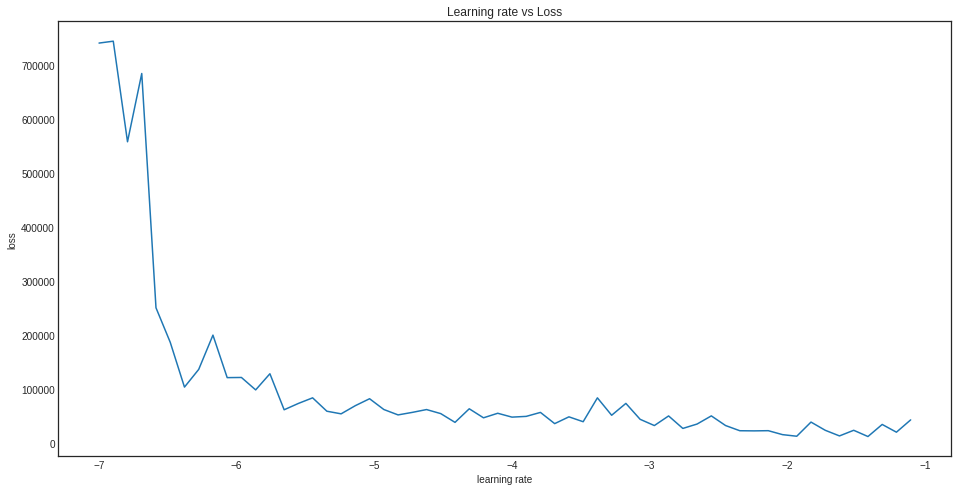

In [59]:
from proto.dl.utils.clr import LRFinder

# to finish this, change the optimizer to SGD and follow the rest of the tutorial
# https://github.com/titu1994/keras-one-cycle

lr_callback = LRFinder(df_X_train.shape[0], BATCH_SIZE,
                       minimum_lr=1e-7, maximum_lr=1e-1,
                       #validation_data=(X_test, y_test),
                       lr_scale='exp', save_dir='models')

# Ensure that number of epochs = 1 when calling fit()
model.fit(X_train, y_train, epochs=1, batch_size=BATCH_SIZE, callbacks=[lr_callback])
lr_callback.plot_schedule()

#### Train model

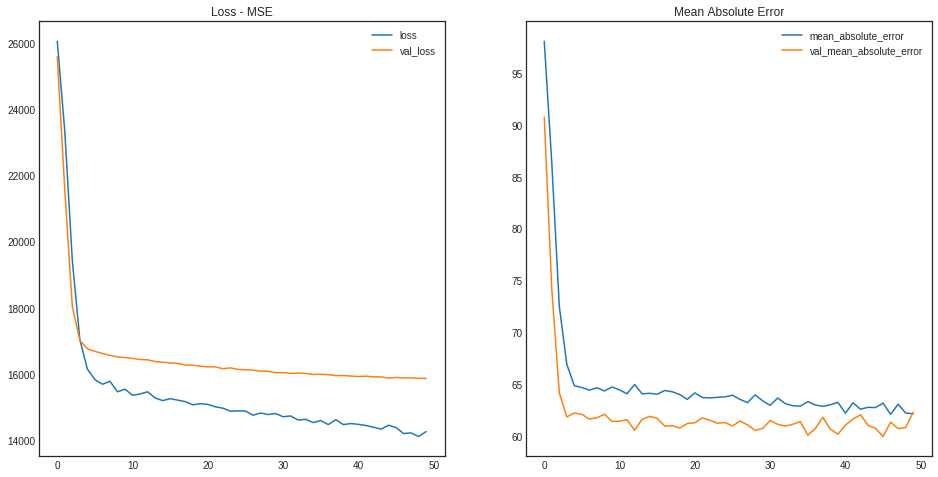

In [64]:
model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    callbacks=[plot_losses, model_checkpoint],
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    shuffle=True, 
    verbose=1
)

#### Plot PR curve on test set

In [65]:
# load model
model = load_model(MODEL_PATH)

# predict test and calculate PR
preds = model.predict(X_test)

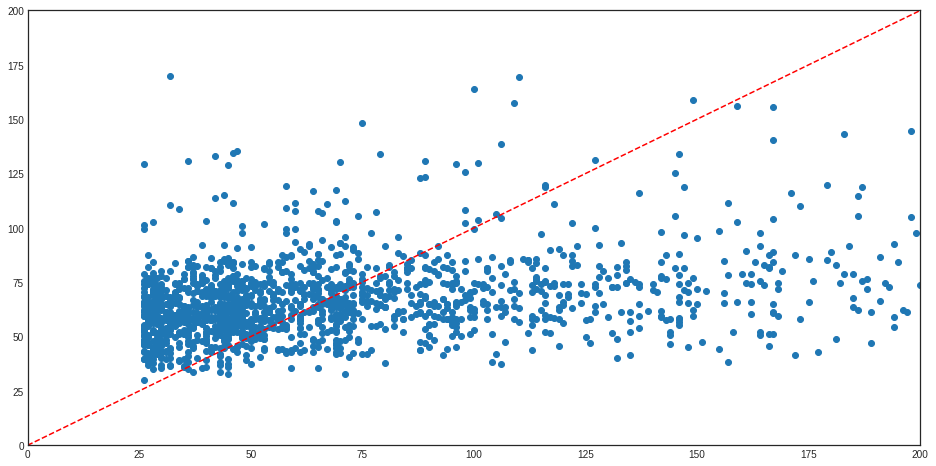

In [73]:
plt.figure()
plt.scatter(y_test, preds.ravel())
plt.plot([0, 200], [0, 200], color='red', linestyle='--')
plt.xlim([0.0, 200])
plt.ylim([0.0, 200])
plt.show()